In [1]:
!module purge
!module load apps/anaconda3
!module load compilers/nvidia/cuda/11.2
!module load compilers/gcc/8.3.0

In [2]:

import cv2
import os
import random

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline

In [4]:
import tensorflow as tf
import tensorflow.keras as keras


In [5]:
tf.__version__

'2.7.0'

In [6]:
tf.random.set_seed(42)
np.random.seed(42)


In [7]:
train_dir = "/home/191112024/splited_dataset/AGCCPF/train"
test_dir = "/home/191112024/splited_dataset/AGCCPF/test"
valid_dir = "/home/191112024/splited_dataset/AGCCPF/validate"


In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# !unzip AGCCPF.zip

In [11]:

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

valid_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=True
        )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical',
        shuffle=False
        )

Found 5253 images belonging to 3 classes.
Found 1315 images belonging to 3 classes.
Found 1644 images belonging to 3 classes.


In [12]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [13]:
from tensorflow.keras import optimizers

In [14]:
input_layer=layers.Input((224, 224, 3))
from tensorflow.keras.applications import VGG16,DenseNet121
conv_base_1 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))(input_layer)


# conv_base = EfficientNetB7(weights='imagenet',
#                   include_top=False,
#                   input_shape=(200, 200, 3))

conv_base_2 = DenseNet121(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))(input_layer)

# conv_base = MobileNetV2(weights='imagenet',
#                   include_top=False,
#                   input_shape=(224, 224, 3))

In [15]:
# model_1 = keras.models.Sequential()
model_1=conv_base_1
model_1=keras.layers.GlobalAveragePooling2D()(model_1)
model_1=keras.layers.Dense(3, activation='relu')(model_1)

# model_2 = keras.models.Sequential()
model_2=conv_base_2
model_2=keras.layers.GlobalAveragePooling2D()(model_2)
model_2=keras.layers.Dense(3, activation='relu')(model_2)

merge=layers.Concatenate()([model_1,model_2])
result=layers.Dense(3, activation='softmax')(merge)

model=keras.models.Model(input_layer,result)



In [16]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(150, 150, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

/home/191112024/.local/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "MobileNet_model.h5", save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True)


In [18]:
model.summary(0)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_1[0][0]']                
                                                                                                  
 densenet121 (Functional)       (None, 7, 7, 1024)   7037504     ['input_1[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['vgg16[0][0]']              

In [19]:
history = model.fit(train_generator,
                    steps_per_epoch=260,
                    epochs=50,
                    validation_data=valid_generator,
                    validation_steps=60,
                    callbacks=[checkpoint_cb])


Epoch 1/50
260/260 [==============================] - 824s 3s/step - loss: 1.0577 - acc: 0.4129 - recall: 0.1090 - precision: 0.5970 - val_loss: 1.0292 - val_acc: 0.4842 - val_recall: 0.1758 - val_precision: 0.5877
Epoch 2/50
260/260 [==============================] - 809s 3s/step - loss: 0.9953 - acc: 0.5036 - recall: 0.2336 - precision: 0.6237 - val_loss: 0.9705 - val_acc: 0.5317 - val_recall: 0.3175 - val_precision: 0.6236
Epoch 3/50
260/260 [==============================] - 810s 3s/step - loss: 0.9391 - acc: 0.5575 - recall: 0.3174 - precision: 0.6522 - val_loss: 0.9376 - val_acc: 0.5500 - val_recall: 0.3825 - val_precision: 0.6322
Epoch 4/50
260/260 [==============================] - 810s 3s/step - loss: 0.8965 - acc: 0.5921 - recall: 0.3888 - precision: 0.6826 - val_loss: 0.9283 - val_acc: 0.5758 - val_recall: 0.4600 - val_precision: 0.6273
Epoch 5/50
260/260 [==============================] - 810s 3s/step - loss: 0.8645 - acc: 0.6081 - recall: 0.4365 - precision: 0.6933 - val_l

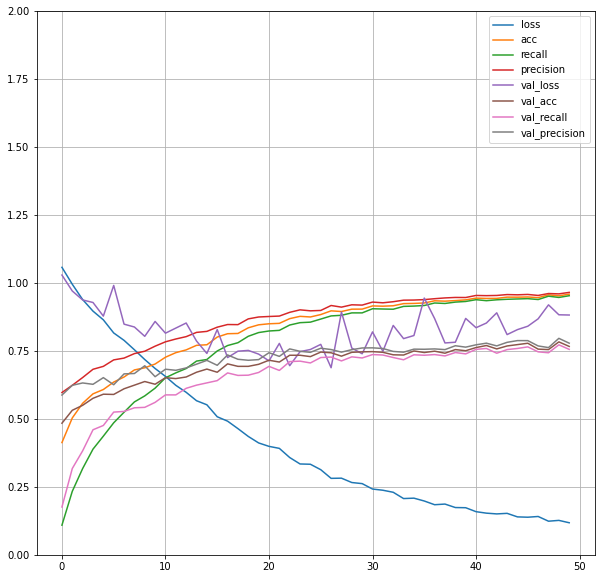

In [20]:
pd.DataFrame(history.history).plot(figsize=(10, 10))
plt.ylim((0,2))
plt.grid(True)
plt.show()

In [21]:
model.evaluate(test_generator)

83/83 [==============================] - 30s 365ms/step - loss: 0.9078 - acc: 0.7682 - recall: 0.7591 - precision: 0.7761


[0.9078066349029541,
 0.7682482004165649,
 0.7591241002082825,
 0.7761194109916687]

In [22]:
x=model.predict(test_generator)

In [23]:
pred=np.argmax(x, axis=-1)
pred

array([0, 0, 0, ..., 1, 2, 2])

In [24]:
actual=test_generator.labels
actual

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [25]:
pred=np.argmax(x, axis=-1)

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[185,  69,  34],
       [ 37, 724, 109],
       [ 10, 122, 354]])

In [27]:
x=model.predict(test_generator)
actual=test_generator.labels
pred=np.argmax(x, axis=-1)
from sklearn.metrics import confusion_matrix
confusion_matrix(actual,pred)

array([[185,  69,  34],
       [ 37, 724, 109],
       [ 10, 122, 354]])